In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import numpy as np
from scipy import stats
import seaborn as sns
from functools import reduce
pd.options.mode.chained_assignment = None 
from statistics import mean
from Profile_Generation import *
import warnings
warnings.simplefilter('ignore', np.RankWarning)
from scipy.optimize import curve_fit
import matplotlib.patches as patches

In [12]:
from scipy.optimize import curve_fit
input_file = 'Retrospective Liver Transplant Data.xlsx'

# Create dictionaries to store information for individual patients
df = {}
quad_cal_pred = {}
linear_cal_pred = {}
df_Q_Cum = {}
df_Q_Cum_input = {}
df_Q_Cum_origin_int_input = {}
df_Q_Cum_origin_int = {}
df_Q_PPM = {}
df_Q_PPM_origin_int = {}
df_L_Cum = {}
df_L_Cum_input = {}
df_L_Cum_origin_int = {}
df_L_Cum_origin_int_input = {}
df_L_PPM = {}
df_L_PPM_origin_int = {}
df_Q_RW_input = {}
df_Q_RW = {}
df_L_RW_input = {}
df_L_RW = {}
df_RW = {}
df_Q_Cum_origin_dp_input = {}
df_Q_Cum_origin_dp = {}
df_L_Cum_origin_dp_input = {}
df_L_Cum_origin_dp = {}
df_Q_PPM_origin_dp = {}
df_L_PPM_origin_dp = {}
df_PPM_origin_dp = {}

# Define lists and parameters
patients_to_exclude = []
rows_to_skip = 17 # Number of rows to skip before reaching patient tac data
patient_list = ['84', '114', '117', '118', '120', '121', '122', '123', '125', '126', 
               '129', '130', '131', '132', '133', '138']

# Loop through patients
for patient in patient_list:
    
    # 1. Data cleaning: 
    
    # Read individual patient data from excel, shift tac level one cell up, remove "mg" and "ng" from values
    df[patient] = read_indiv_patient_data(input_file, patient, rows_to_skip)

    # 2. Data selection: 
    
    # Keep ideal data only
    df[patient] = keep_ideal_data(df[patient]) # If there are >1 large chunks with longest length, an error will be printed
    df[patient] = df[patient].reset_index(drop=True) 
    
    # Select data for calibration and subsequent predictions
    # Print patients with insufficient data for calibration and with <3 predictions
    quad_cal_pred[patient] = cal_pred_data(df, patient, quad_cal_pred, patients_to_exclude, 2)
    linear_cal_pred[patient] = cal_pred_data(df, patient, linear_cal_pred, patients_to_exclude, 1)

# Print list of unique patients to exclude generated from cal_pred function
patients_to_exclude = np.array(patients_to_exclude)
patients_to_exclude = np.unique(patients_to_exclude)
print("Patients to exclude from CURATE.AI predictions: ", patients_to_exclude)

# Exclude chosen patients from list
patient_list = [patient for patient in patient_list if patient not in patients_to_exclude]

# 3. Apply CURATE.AI methods to all remaining patients:

# Loop through patients
for patient in patient_list:

    # Perform all methods except rolling window and origin_dp methods
    df_Q_Cum_input[patient], df_Q_Cum[patient] = Q_Cum(quad_cal_pred[patient])
    df_Q_Cum_origin_int_input[patient], df_Q_Cum_origin_int[patient] = Q_Cum_origin_int(quad_cal_pred[patient])
    df_Q_PPM[patient] = Q_PPM(quad_cal_pred[patient])
    df_Q_PPM_origin_int[patient] = Q_PPM_origin_int(quad_cal_pred[patient])
    df_L_Cum_input[patient], df_L_Cum[patient] = L_Cum(linear_cal_pred[patient])
    df_L_Cum_origin_int_input[patient], df_L_Cum_origin_int[patient] = L_Cum_origin_int(linear_cal_pred[patient])
    df_L_PPM[patient] = L_PPM(linear_cal_pred[patient])
    df_L_PPM_origin_int[patient] = L_PPM_origin_int(linear_cal_pred[patient])
    
    # Perform rolling window methods which require extra data selection step
    df_Q_RW_input[patient] = select_RW_data(quad_cal_pred[patient], 3) 
    df_Q_RW[patient] = RW(df_Q_RW_input[patient], patient, df_RW, 3)
    df_L_RW_input[patient] = select_RW_data(linear_cal_pred[patient], 2)
    df_L_RW[patient] = RW(df_L_RW_input[patient], patient, df_RW, 2)
    
    # Perform Cumulative origin_dp methods with require extra data selection step
    df_Q_Cum_origin_dp_input[patient] = prep_Cum_origin_dp_data(quad_cal_pred[patient], 4, 2)
    df_Q_Cum_origin_dp[patient] = Cum_origin_dp(df_Q_Cum_origin_dp, patient, df_Q_Cum_origin_dp_input[patient], 4, 2)
    df_L_Cum_origin_dp_input[patient] = prep_Cum_origin_dp_data(linear_cal_pred[patient], 3, 1)
    df_L_Cum_origin_dp[patient] = Cum_origin_dp(df_L_Cum_origin_dp, patient, df_L_Cum_origin_dp_input[patient], 3, 1)
    
    # Perform PPM origin_dp methods
    df_Q_PPM_origin_dp[patient] = PPM_origin_dp(quad_cal_pred[patient], 2, df_Q_PPM_origin_dp, patient)
    df_L_PPM_origin_dp[patient] = PPM_origin_dp(linear_cal_pred[patient], 1, df_L_PPM_origin_dp, patient)

# 4. Export results for checking (will refactor this giant part later!)

# Create list of method dictionaries
dict_list = [df_Q_Cum, df_Q_Cum_origin_int, df_Q_Cum_origin_dp,
            df_Q_PPM, df_Q_PPM_origin_int, df_Q_PPM_origin_dp, df_Q_RW,
            df_L_Cum, df_L_Cum_origin_int, df_L_Cum_origin_dp,
            df_L_PPM, df_L_PPM_origin_int, df_L_PPM_origin_dp,
            df_L_RW]

# Create list of method names
method_names = ["Q_Cum", "Q_Cum_origin_int", "Q_Cum_origin_dp",
                "Q_PPM", "Q_PPM_origin_int", "Q_PPM_origin_dp", "Q_RW",
                "L_Cum", "L_Cum_origin_int", "L_Cum_origin_dp",
                "L_PPM", "L_PPM_origin_int", "L_PPM_origin_dp", "L_RW"]

# Create list of method_input dictionaries
input_dict_list = [df_Q_Cum_input, df_Q_Cum_origin_int_input, df_Q_Cum_origin_dp_input, df_Q_RW_input,
                   df_L_Cum_input, df_L_Cum_origin_int_input, df_L_Cum_origin_dp_input, df_L_RW_input]

# Create list of method names for prediction input dataframes
input_method_names = ["Q_Cum", "Q_Cum_origin_int", "Q_Cum_origin_dp", "Q_RW",
                "L_Cum", "L_Cum_origin_int", "L_Cum_origin_dp", "L_RW"]

# Create combined dataframe of raw patient data
patients_df = create_patients_df(patient_list, df)

# Create combined dataframe of results of predictions
results_df = create_results_df(dict_list, method_names, patient_list)

# Create combined dataframe with calibration and prediction data for linear and quadratic methods
cal_pred_df = create_cal_pred_df(patient_list, linear_cal_pred, quad_cal_pred)

# Create combined dataframe with each row containing data required for one prediciton
prediction_input_df = create_prediction_input_df(input_dict_list, patient_list, input_method_names)

# Prepare dataframes for export (add type column, sort, reset index)
cal_pred_df, prediction_input_df, results_df = prep_df_for_export(cal_pred_df, 
                                                                  prediction_input_df, 
                                                                  results_df, 
                                                                  patient_list, 
                                                                  method_names)

# Write dataframes to excel
# List of dataframes and sheet names
dfs = [patients_df.set_index('patient'), cal_pred_df.set_index('patient'),\
       prediction_input_df.set_index('patient'), results_df.set_index('patient')]
sheets = ['Patient','Calibration Prediction','Prediction Input', 'Results']    

# Run function
dfs_tabs(dfs, sheets, 'All_Data.xlsx')

117 : No. of predictions  (for quadratic)  is <3:  0
117 : No. of predictions  (for linear)  is <3:  1
121 : Insufficient unique dose-response pairs for quadratic calibration!
121 : Insufficient unique dose-response pairs for linear calibration!
126 : Insufficient unique dose-response pairs for quadratic calibration!
130 : No. of predictions  (for quadratic)  is <3:  1
130 : No. of predictions  (for linear)  is <3:  2
133 : Insufficient unique dose-response pairs for quadratic calibration!
Patients to exclude from CURATE.AI predictions:  ['117' '121' '126' '130' '133']


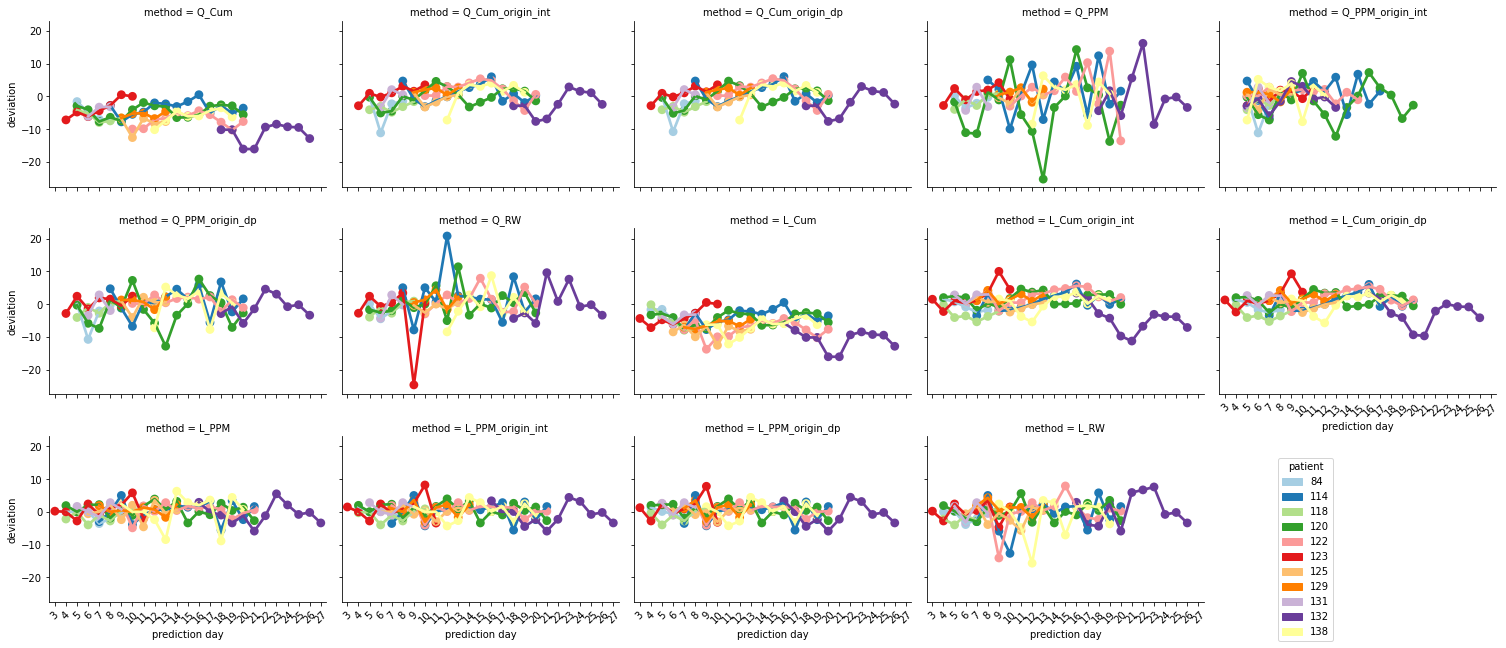

In [4]:
##### PLOTTING #####
# FacetGrid Plot by Method

# Subset dataframe with deviation, prediction day, method, patient
plot_df = results_df[['deviation', 'prediction day', 'method', 'patient']]

# Set up lists
hue_order = [patient for patient in patient_list]
order = [num for num in range(int(plot_df['prediction day'].min()),
                                  int(plot_df['prediction day'].max()+1))]
labels = hue_order
colors = sns.color_palette("Paired").as_hex()[:len(labels)]
handles = [patches.Patch(color=col, label=lab) for col, lab in zip(colors, labels)]

# Set up facet grid
g = sns.FacetGrid(plot_df, col_wrap=5, col="method", hue="patient", palette=colors, aspect=1.4)

# Visualise data on grid

g.map(sns.pointplot, "prediction day", "deviation", hue_order=hue_order, order=order)

# Set xtick labels to rotate
g.set_xticklabels(rotation=45)

# Add legend with plt.legend, add_legend has a bug
plt.legend(handles=handles, title="patient", loc="upper left", bbox_to_anchor=(1.25,0.9))


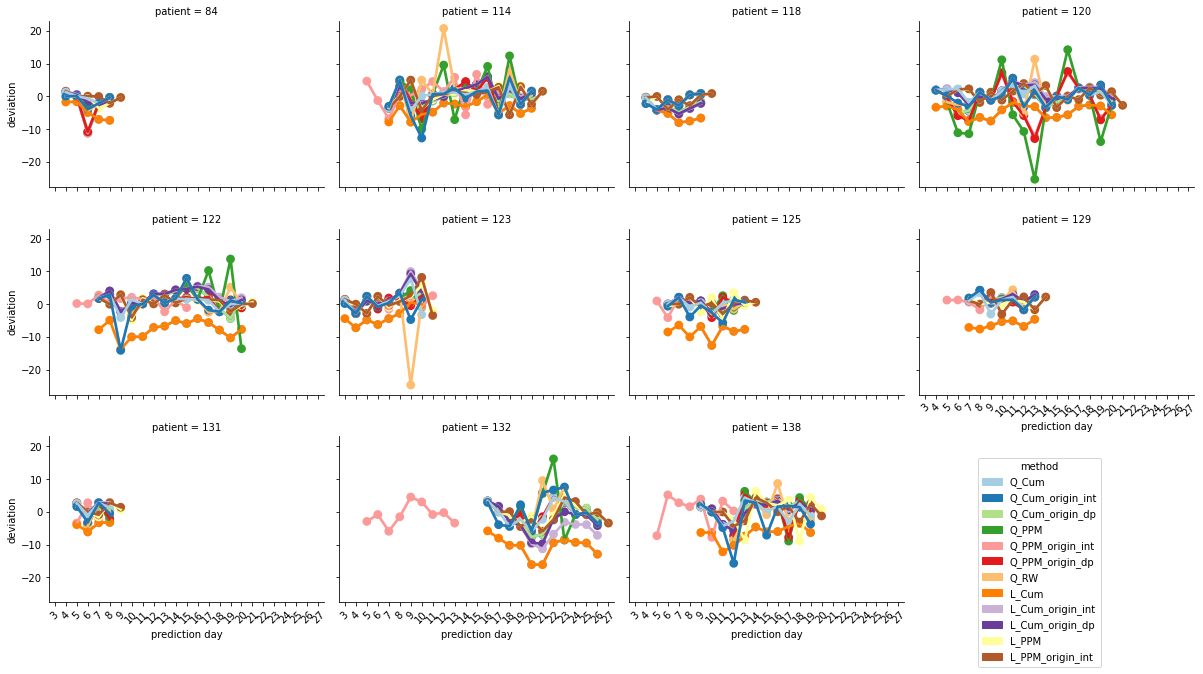

In [5]:
##### PLOTTING #####
# FacetGrid Plot by Patient

# Subset dataframe with deviation, prediction day, method, patient
plot_df = results_df[['deviation', 'prediction day', 'method', 'patient']]

# Set up lists
hue_order = [method for method in method_names]
order = [num for num in range(int(plot_df['prediction day'].min()),
                                  int(plot_df['prediction day'].max()+1))]
labels = hue_order
colors = sns.color_palette("Paired").as_hex()[:len(labels)]
handles = [patches.Patch(color=col, label=lab) for col, lab in zip(colors, labels)]

# Set up facet grid
g = sns.FacetGrid(plot_df, col_wrap=4, col="patient", hue="method", palette=colors, aspect=1.4)

# Visualise data on grid

g.map(sns.pointplot, "prediction day", "deviation", hue_order=hue_order, order=order)

# Set xtick labels to rotate
g.set_xticklabels(rotation=45)

# Add legend with plt.legend, add_legend has a bug
plt.legend(handles=handles, title="method", loc="upper left", bbox_to_anchor=(1.25,0.9))


In [ ]:
# patient_df = {}
# # Plot deviation against prediction day for one patient across all methods

# # Loop through patients
# for patient_temp in patient_list:
    
#     # Extract information from one patient only    
#     patient_df[patient_temp] = results_df[results_df['patient']==patient_temp]

#     # Set palette
#     sns.set_palette("Paired")

#     # Plot
#     plt.figure(figsize=(20,5))
#     ax = sns.catplot(x="prediction day", y="deviation", hue="method", kind="point", data=patient_df[patient_temp], aspect=1.25)
#     plt.xticks(rotation=45, horizontalalignment='right', fontweight='light', fontsize=10)
#     plt.xlabel("Prediction Day")
#     plt.ylabel("Deviation")
#     plt.title("Patient " + patient_temp)
#     # plt.show()

# sub_df = patient_df['132']
# sub_df[sub_df['method']=='L_PPM_origin_int']
# # sub_df = results_df[results_df['method']=='L_Cum_origin_int']
# # sub_df[sub_df['patient']=='132']

In [ ]:
# [patient for patient in patient_list]
# # ['84', '114', '117', '118', '120', '121', '122', '123', '125', '126', 
#                # '129', '130', '131', '132', '133', '138']

In [ ]:
# # Create dataframe for every method
# dfnames = ['Q_Cum', 'Q_Cum_origin_int', 'Q_Cum_origin_dp']

# for x in dfnames: exec(x + ' = pd.DataFrame()')

# i = 0

# # Loop through methods
# method_dataframes = [df_Q_Cum, df_Q_Cum_origin_int, df_Q_Cum_origin_dp,
#                     df_Q_PPM, df_Q_PPM_origin_int, df_Q_Cum_origin_dp,
#                     df_Q_RW,
#                     df_L_Cum, df_L_Cum_origin_int, df_L_Cum_origin_dp,
#                     df_L_PPM, df_L_PPM_origin_int, df_L_Cum_origin_dp,
#                     df_L_RW]
# for dataframe in range(1, len(method_dataframes) - 1):

#     # Loop through patients
#     for patient in patient_list:
#         print(i)
#         i = i + 1
#         # Add patient column to all sub-dataframes per methods
#         dataframe[patient].insert(0, 'patient', patient)

#         # Concat sub-dataframes 
        

# # Write to excel

# print(df_Q_Cum['138'])

In [ ]:
# methods = ['Q_Cum', 'Q_PPM', 'Q_RW', 'L_Cum', 'L_PPM', 'L_RW']

# df_Q_Cum['method'] = 'Q_Cum'
# df_Q_PPM['method'] = 'Q_PPM'
# df_Q_RW['method'] = 'Q_RW'
# df_L_Cum['method'] = 'L_Cum'
# df_L_PPM['method'] = 'L_PPM'
# df_L_RW['method'] = 'L_RW'
# df_Q_Cum_0['method'] = 'Q_Cum_0'
# df_Q_PPM_0['method'] = 'Q_PPM_0'
# df_Q_RW_0['method'] = 'Q_RW_0'
# df_L_Cum_0['method'] = 'L_Cum_0'
# df_L_PPM_0['method'] = 'L_PPM_0'
# df_L_RW_0['method'] = 'L_RW_0'
# df_all_methods = pd.concat([df_Q_Cum, df_Q_PPM, df_Q_RW, df_L_Cum, df_L_PPM, df_L_RW,
#                            df_Q_Cum_0, df_Q_PPM_0, df_Q_RW_0, df_L_Cum_0, df_L_PPM_0, df_L_RW_0])
# df_all_methods = df_all_methods.reset_index(drop = True)

# # Remove rows with prediction day 4
# df_all_methods.drop(df_all_methods[df_all_methods['prediction day'] <= 4].index, inplace=True)
# df_all_methods = df_all_methods.reset_index(drop = True)
# df_all_methods.columns = ['pred_day', 'a', 'b', 'c',
#                                        'prediction', 'deviation', 'abs_dev', 'method']


# df_all_methods['method'] = df_all_methods['method'].astype('category')
# df_all_methods['method'].cat.reorder_categories(['Q_Cum', 'Q_PPM', 'Q_RW', 
#                                                  'L_Cum', 'L_PPM', 'L_RW',
#                                                 'Q_Cum_0', 'Q_PPM_0', 'Q_RW_0', 
#                                                  'L_Cum_0', 'L_PPM_0', 'L_RW_0'])

# # create color mapping based on all unique values of ticker
# method = df_all_methods.method.unique()
# colors = sns.color_palette('Paired')  # get a number of colors
# cmap = dict(zip(method, colors))  # zip values to colors

# # plot
# plt.figure(figsize=(16, 10))
# sns.lineplot(x='pred_day', y='deviation', hue='method', data=df_all_methods, palette=cmap)

# # plt.tight_layout()
# plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
# plt.xlabel("Day of Prediction")
# plt.ylabel("Deviation")
# plt.title("Deviation of Prediction from Actual Value")

# # plt.savefig('test.png', bbox_inches="tight", dpi=300)

In [ ]:
# # # Plot mean deviation

# methods = ['L_Cum', 'L_Cum_0', 'L_PPM', 'L_PPM_0', 'L_RW', 'L_RW_0', 
#            'Q_Cum', 'Q_Cum_0', 'Q_PPM', 'Q_PPM_0', 'Q_RW', 'Q_RW_0']
# x_pos = np.arange(len(methods))
# CTEs = df_all_methods.groupby("method").deviation.mean()
# error = df_all_methods.groupby("method").deviation.std()

# # Build the plot
# fig, ax = plt.subplots()
# ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
# ax.set_ylabel('Deviation (Mean \u00B1 SD)')
# ax.set_xticks(x_pos)
# ax.set_xticklabels(methods)
# ax.set_title('Deviation of Predicted from Actual Value (Mean \u00B1 SD)')
# ax.yaxis.grid(True)
# plt.xticks(rotation=45)

# # Save the figure and show
# plt.tight_layout()
# # plt.savefig('all_methods_mean_deviation.png', bbox_inches="tight", dpi=300)
# plt.show()

# error

In [ ]:
# # Plot median of deviation
# methods = ['L_Cum', 'L_Cum_0', 'L_PPM', 'L_PPM_0', 'L_RW', 'L_RW_0', 
#            'Q_Cum', 'Q_Cum_0', 'Q_PPM', 'Q_PPM_0', 'Q_RW', 'Q_RW_0']
# x_pos = np.arange(len(methods))

# df = df_all_methods.pivot("pred_day", "method" , "deviation")

# data = [df['L_Cum'], df['L_Cum_0'], df['L_PPM'], df['L_PPM_0'], df['L_RW'], df['L_RW_0'], 
#            df['Q_Cum'], df['Q_Cum_0'], df['Q_PPM'], df['Q_PPM_0'], df['Q_RW'], df['Q_RW_0']]

# fig, ax = plt.subplots()
# ax.set_title('Deviation of Predicted from Actual Value (Median)')
# ax.boxplot(data)
# ax.set_xticklabels(methods)
# plt.ylabel('Deviation (Median)')
# plt.xticks(rotation=45)
# # plt.savefig('all_methods_median_dev.png', bbox_inches="tight", dpi=300)
# plt.show()

In [ ]:
# # Plot RMSE and MAE
# df_rmse_MAE = pd.DataFrame()

# ## Plot RMSE
# methods = ['L_Cum', 'L_Cum_0', 'L_PPM', 'L_PPM_0', 'L_RW', 'L_RW_0', 
#            'Q_Cum', 'Q_Cum_0', 'Q_PPM', 'Q_PPM_0', 'Q_RW', 'Q_RW_0']

# df = df_all_methods.pivot("pred_day", "method" , "deviation")

# rmse_Q_Cum = np.sqrt(mean(df['Q_Cum']**2))
# rmse_Q_PPM = np.sqrt(mean(df['Q_PPM']**2))
# rmse_Q_RW = np.sqrt(mean(df['Q_RW']**2))
# rmse_L_Cum = np.sqrt(mean(df['L_Cum']**2))
# rmse_L_PPM = np.sqrt(mean(df['Q_Cum']**2))
# rmse_L_RW = np.sqrt(mean(df['L_RW']**2))
# rmse_Q_Cum_0 = np.sqrt(mean(df['Q_Cum_0']**2))
# rmse_Q_PPM_0 = np.sqrt(mean(df['Q_PPM_0']**2))
# rmse_Q_RW_0 = np.sqrt(mean(df['Q_RW_0']**2))
# rmse_L_Cum_0 = np.sqrt(mean(df['L_Cum_0']**2))
# rmse_L_PPM_0 = np.sqrt(mean(df['Q_Cum_0']**2))
# rmse_L_RW_0 = np.sqrt(mean(df['L_RW_0']**2))

# rmse = np.array([rmse_L_Cum, rmse_L_Cum_0, rmse_L_PPM, rmse_L_PPM_0, rmse_L_RW, rmse_L_RW_0,
#                 rmse_Q_Cum, rmse_Q_Cum_0, rmse_Q_PPM, rmse_Q_PPM_0, rmse_Q_RW, rmse_Q_RW_0])

# rmse = pd.DataFrame(rmse.reshape(-1, len(rmse)),columns=methods)
# rmse=rmse.transpose()

# ## Calculate MAE
# MAE_Q_Cum = mean(abs(df['Q_Cum']))
# MAE_Q_PPM = mean(abs(df['Q_PPM']))
# MAE_Q_RW = mean(abs(df['Q_RW']))
# MAE_L_Cum = mean(abs(df['L_Cum']))
# MAE_L_PPM = mean(abs(df['L_PPM']))
# MAE_L_RW = mean(abs(df['L_RW']))
# MAE_Q_Cum_0 = mean(abs(df['Q_Cum_0']))
# MAE_Q_PPM_0 = mean(abs(df['Q_PPM_0']))
# MAE_Q_RW_0 = mean(abs(df['Q_RW_0']))
# MAE_L_Cum_0 = mean(abs(df['L_Cum_0']))
# MAE_L_PPM_0 = mean(abs(df['L_PPM_0']))
# MAE_L_RW_0 = mean(abs(df['L_RW_0']))

# MAE = np.array([MAE_L_Cum, MAE_L_Cum_0, MAE_L_PPM, MAE_L_PPM_0, MAE_L_RW, MAE_L_RW_0,
#                 MAE_Q_Cum, MAE_Q_Cum_0, MAE_Q_PPM, MAE_Q_PPM_0, MAE_Q_RW, MAE_Q_RW_0])

# MAE = pd.DataFrame(MAE.reshape(-1, len(MAE)),columns=methods)
# MAE=MAE.transpose()

# df_rmse_MAE = df_rmse_MAE.append(rmse)
# df_rmse_MAE = pd.concat([df_rmse_MAE, MAE], axis=1)
# df_rmse_MAE.columns = ['RMSE', 'MAE']

# df_rmse_MAE.index=['L_Cum', 'L_Cum_0', 'L_PPM', 'L_PPM_0', 'L_RW', 'L_RW_0', 
#            'Q_Cum', 'Q_Cum_0', 'Q_PPM', 'Q_PPM_0', 'Q_RW', 'Q_RW_0']

# df_rmse_MAE.plot()
# plt.xticks(np.arange(len(df_rmse_MAE.index)), df_rmse_MAE.index, rotation=45)

# plt.ylabel('RMSE and MAE')
# plt.title("RMSE and MAE of Deviation of Predicted from Actual Value")
# plt.xticks(rotation=45)
# # plt.savefig('all_methods_MAE_RMSE.png', bbox_inches="tight", dpi=300)

In [ ]:
# # Plot prediction of all methods
# pred = df_all_methods.pivot("pred_day", "method", "prediction")
# pred['L_Cum'].plot()
# pred['L_Cum_0'].plot()
# pred['L_PPM'].plot()
# pred['L_PPM_0'].plot()
# pred['L_RW'].plot()
# pred['L_RW_0'].plot()
# pred['Q_Cum'].plot()
# pred['Q_Cum_0'].plot()
# pred['Q_PPM'].plot()
# pred['Q_PPM_0'].plot()
# pred['Q_RW'].plot()
# pred['Q_RW_0'].plot()
# plt.axhline(y = 8, color = "black", linestyle = '--')
# plt.axhline(y = 10, color = "black", linestyle = '--')
# plt.legend()
# plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
# plt.xlabel("Day of Prediction")
# plt.ylabel("Prediction")
# plt.title("Prediction of Tac Level")
# # plt.title("Prediction of Tac Level (without Q_PPM, Q_PPM_0, Q_RW, Q_RW_0)")
# plt.tight_layout()
# # plt.savefig('prediction.png', bbox_inches="tight", dpi=300)